# TDT17 - Preprocessing data for YOLO

This notebook is used for all preprocessing of the dataset for the object detection model YOLO. The dataset is provided
as a part of the object description, but can also be found at [this link](https://crddc2022.sekilab.global/data/). Before
being able to feed the images into the model, we have to translate the bounding boxes provided in the dataset into
the format YOLO requires. The bounding boxes provided is on the format `(xmin, ymin, xmax, ymax)`, while YOLO requires
the format `(x, y, width, height)`, where x and y are the coordinates of the center of the bounding box. In addition
to this, this notebook will also split the dataset into training and validation sets. Finally, we move the images into 
the correct folders for YOLO to be able to read them, as the model requires aspecific folder structure.

#### Imports

Importing all necessary libraries for the notebook and defining the paths to the raw data.

In [142]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import lxml.etree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt


raw_base_path = "./Norway"
raw_train_path = os.path.join(raw_base_path, "train")
raw_test_path = os.path.join(raw_base_path, "test")
train_annotations = os.path.join(raw_train_path, "annotations/xmls")
train_images_path = os.path.join(raw_train_path, "images")
test_images_path = os.path.join(raw_test_path, "images")

#### Loading data from xml and converting to dictionary

The data will be translated into this format:

```python
{'image': 'Norway_000000.jpg',
  'size': (3650, 2044, 3),
  'boxes': [
    {'type': 'D00', 'xmin': 1138, 'ymin': 1282, 'xmax': 1169, 'ymax': 1337},
    {'type': 'D20', 'xmin': 1538, 'ymin': 1132, 'xmax': 1629, 'ymax': 1248},
    {'type': 'D00', 'xmin': 1773, 'ymin': 1826, 'xmax': 1863, 'ymax': 2039},
    {'type': 'D00', 'xmin': 1589, 'ymin': 1296, 'xmax': 1625, 'ymax': 1343},
    {'type': 'D00', 'xmin': 1508, 'ymin': 1217, 'xmax': 1527, 'ymax': 1254}
   ]
}
```

We will remove some of the images not containing any bounding boxes, as too many negative samples will make the model 
biased towards predicting no objects in the image. This is decided by the random number in the `if` statement.

In [154]:
def elem2dict(node, attributes=True):
    """
    Convert an lxml.etree node tree into a dict.
    """
    result = {}
    if attributes:
        for item in node.attrib.items():
            key, result[key] = item

    for element in node.iterchildren():
        # Remove namespace prefix
        key = element.tag.split('}')[1] if '}' in element.tag else element.tag

        # Process element as tree element if the inner XML contains non-whitespace content
        if element.text and element.text.strip():
            value = element.text
        else:
            value = elem2dict(element)
        if key in result:
            if type(result[key]) is list:
                result[key].append(value)
            else:
                result[key] = [result[key], value]
        else:
            result[key] = value
    return result


# Converting from xml to dictionary
train_xml = [ET.parse(os.path.join(train_annotations, x)).getroot()
             for x in os.listdir(train_annotations) if x.endswith(".xml")]
train_dicts = [elem2dict(x) for x in train_xml]

# Converting from dictionary to valid data format


def dict2data(dict):
    """
    Convert an dictionary to a nicer data format
    """
    image = dict["filename"] 
    size = (int(dict["size"]["width"]), int(dict["size"]["height"]), 3)
    boxes = []
    if "object" in dict:
        if not type(dict["object"]) is list:
            dict["object"] = [dict["object"]]
        for object in dict["object"]:
            box = {}
            box["type"] = object["name"]
            box["xmin"] = int(round(float(object["bndbox"]["xmin"])))
            box["ymin"] = int(round(float(object["bndbox"]["ymin"])))
            box["xmax"] = int(round(float(object["bndbox"]["xmax"])))
            box["ymax"] = int(round(float(object["bndbox"]["ymax"])))
            boxes.append(box)
    else:
        boxes = []
    return {"image": image, "size": size, "boxes": boxes}


train_data_dicts = [dict2data(x) for x in train_dicts]
train_data_dicts = [x for x in train_data_dicts if len(x["boxes"]) > 0 or (len(x["boxes"]) == 0 and random.random() < 0.33)]

#### Converting to YOLO format

Will create a `.txt` file with the following format for each image, where each line is a bounding box:

```python
0 0.5 0.5 0.1 0.1
1 0.5 0.5 0.1 0.1
```

In [155]:
holetypes = {"D00": 0, "D10": 1, "D20": 2, "D40": 3}
holeids = {0: "D00", 1: "D10", 2: "D20", 3: "D40"}
def convert_to_yolo_format(data):
    """
        Convert data to yolo format
    """
    image = data["image"]
    savefile = os.path.join(train_annotations, image.replace(".jpg", ".txt"))
    size = data["size"]
    boxes = data["boxes"]
    yolo_boxes = []
    filedata = []
    for box in boxes:
        type = holetypes[box["type"]]
        x = (box["xmin"] + box["xmax"]) / 2
        y = (box["ymin"] + box["ymax"]) / 2
        w = box["xmax"] - box["xmin"]
        h = box["ymax"] - box["ymin"]
        x /= size[0]
        y /= size[1]
        w /= size[0]
        h /= size[1]
        yolo_boxes.append((type, x, y, w, h))
        filedata.append("{} {:.4f} {:.4f} {:.4f} {:.4f}".format(type, x, y, w, h))
    with open(savefile, "w") as f:
        f.write("\n".join(filedata))

for data in tqdm(train_data_dicts):
    convert_to_yolo_format(data)

100%|██████████| 4618/4618 [00:00<00:00, 4643.28it/s]


#### Validating that the boxes have been translated correctly

As we have translated the bounding boxes into the format YOLO requires, we can now validate that the boxes have been
translated correctly. We will do this by loading the image and drawing the bounding boxes on top of the image.

['0 0.1345 0.7812 0.2674 0.2915']


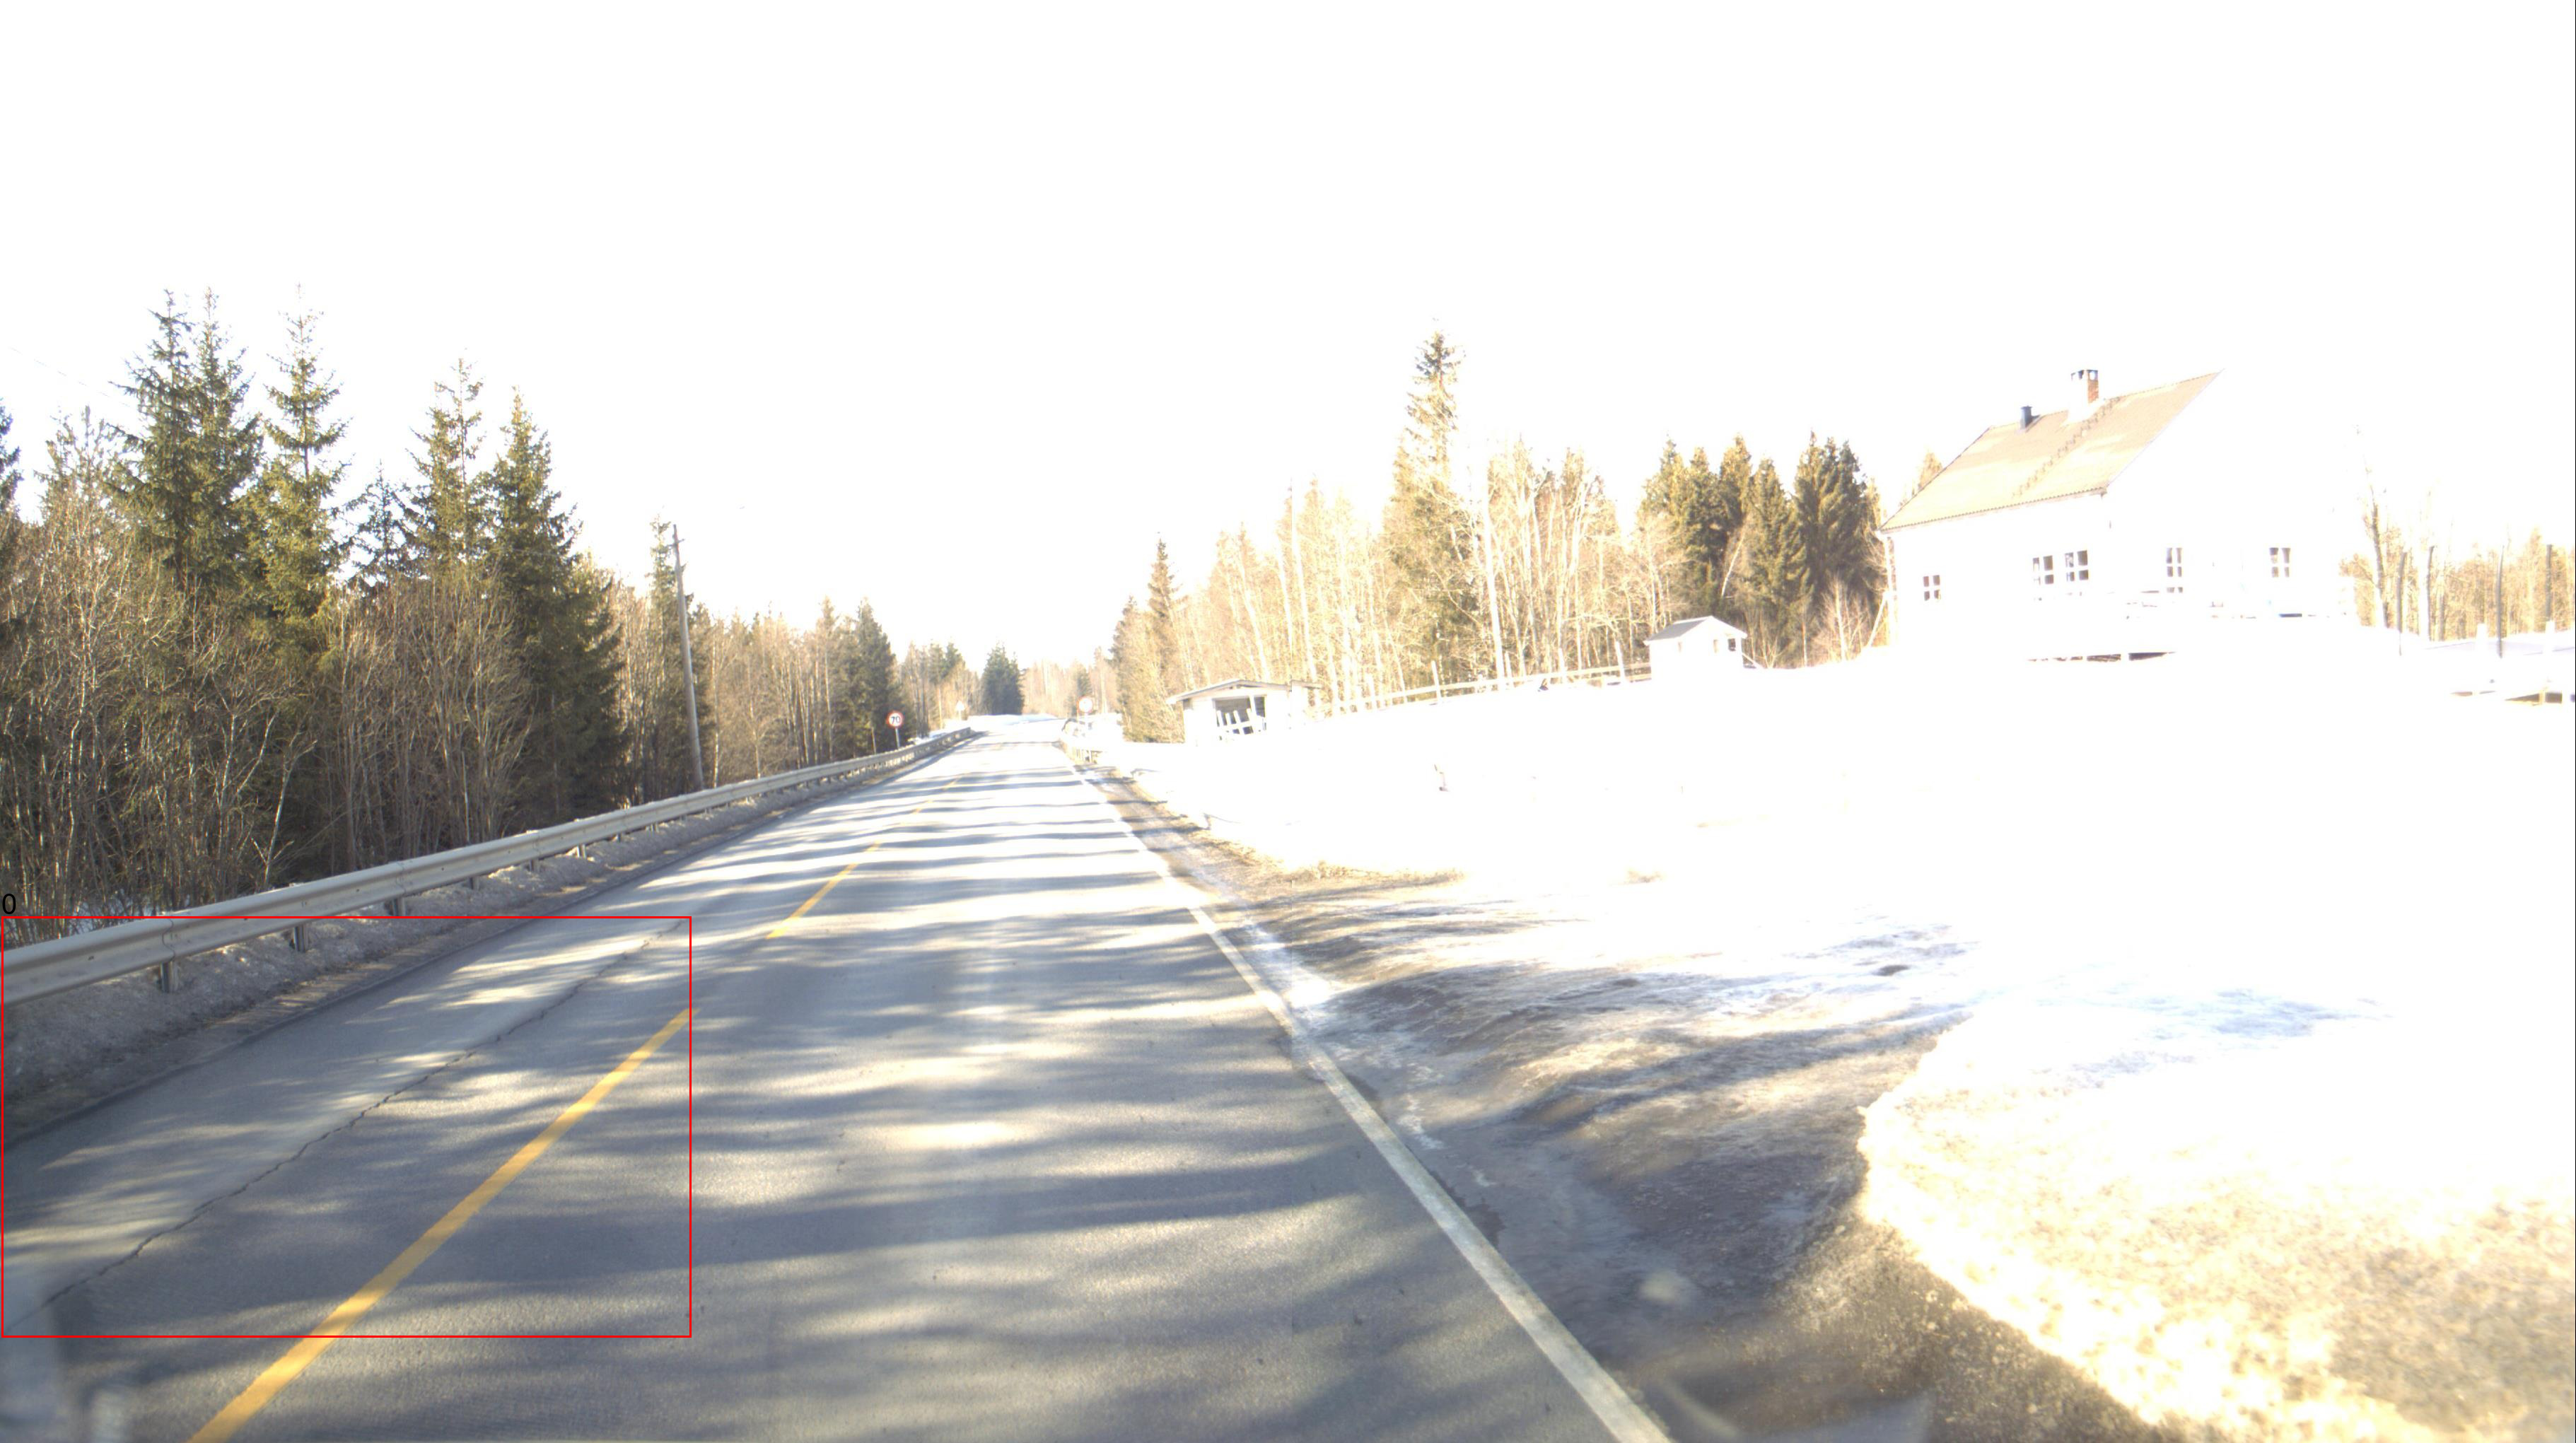

In [157]:
# Fetching a random image
random_dict = random.choice(train_data_dicts)

# Defining function for plotting YOLO bounding boxes
def plot_yolo_bounding_boxes(dict):
    """
        Plot bounding boxes on an image
    """
    img = Image.open(os.path.join(train_images_path, dict["image"]))
    label_file = os.path.join(train_annotations, dict["image"].replace(".jpg", ".txt"))
    with open(label_file, "r") as f:
        labels = f.readlines()
    print("Labels", labels)
    labels = [x.strip().split(" ") for x in labels]
    if len(labels) > 0:
        labels = [(int(x[0]), float(x[1]), float(x[2]), float(x[3]), float(x[4])) for x in labels]
    draw = ImageDraw.Draw(img)
    for box in labels:
        type = box[0]
        x = box[1] * img.width
        y = box[2] * img.height
        w = box[3] * img.width
        h = box[4] * img.height
        draw.rectangle(((x-w/2, y-h/2), (x+w/2, y+h/2)), outline="red", width=3)
        draw.text((x-w/2, (y-h/2)-40), str(type), fill="black", font=ImageFont.truetype("arial.ttf", 40))
    return img

plot_yolo_bounding_boxes(random_dict)

#### Splitting data into training and validation sets

We will split the data into training and validation sets, where the validation set will be 25% (6 to 2) of the total 
dataset as described in the project description. 



In [159]:
train_images = [os.path.join(train_images_path, x["image"]) for x in train_data_dicts]
train_labels = [os.path.join(train_annotations, x["image"].replace(".jpg", ".txt")) for x in train_data_dicts]

In [160]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.25, random_state=69)

len(train_images), len(val_images), len(train_labels), len(val_labels)

(3463, 1155, 3463, 1155)

#### Moving images into correct folders

The images are now ready to be fed into the model. However, YOLO requires a specific folder structure, where the images
are stored in a folder called `images` and the `.txt` files are stored in a folder called `labels`. We will create these
folders and move the images and labels into the correct folders - namely in the dicectory `yolodata`

In [161]:
def copy_and_move_files(files, destination):
    """
        Copy and move files to destination
    """
    for file in tqdm(files):
        shutil.copy(file, destination)

# Copying images
copy_and_move_files(train_images, "./yolodata/train/images/train")
copy_and_move_files(val_images, "./yolodata/train/images/val")

# Copying labels
copy_and_move_files(train_labels, "./yolodata/train/labels/train")
copy_and_move_files(val_labels, "./yolodata/train/labels/val")

100%|██████████| 1155/1155 [00:02<00:00, 483.86it/s]


#### YOLO ready

Now we are ready to feed the data into the YOLO model. The model will be trained on the training set and validated on the
validation set. The rest of the code is located in `main.ipynb`, as this notebook is only used for preprocessing the data.